In [69]:
import pandas as pd
import numpy as np
import hvplot.pandas
from IPython.display import HTML
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import warnings
warnings.filterwarnings('ignore')

path = 'D:\\Projects\\forecasting-challenge-4i\\'

# 1. Data Loading

In [70]:
data = pd.read_csv(path+'data\\TFP.csv')
display(data.head(3))

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451


In [71]:
print(f'Number of Samples: {data.shape[0]}')
print(f'Number of Features: {data.shape[1]}')

Number of Samples: 186
Number of Features: 3


# 2. EDA

In [72]:
series_aux = data.dtypes
df_aux = pd.DataFrame({
                        'Feature' : series_aux.index,
                        'Data Type' : series_aux.values
})
display(HTML('<span style="font-weight:bold">' + 'Features Data Types'\
       + '</span>'), df_aux)

,Feature,Data Type
0,isocode,object
1,year,int64
2,rtfpna,float64


In [73]:
series_aux = data.isnull().sum()
df_aux = pd.DataFrame({
                        'Feature' : series_aux.index,
                        'Data Type' : series_aux.values
})
display(HTML('<span style="font-weight:bold">' + 'Features Missing Values'\
       + '</span>'), df_aux)

,Feature,Data Type
0,isocode,0
1,year,0
2,rtfpna,0


In [74]:
display(HTML('<span style="font-weight:bold">' + 'Dataset Countries and Year Range'\
       + '</span>'))
print(f'Countries: {list(data["isocode"].unique())}')
print(f'Years: {list(data["year"].unique())}')

Countries: ['USA', 'CAN', 'MEX']
Years: [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]


In [75]:
data.rename(columns={'isocode' :  'country'}, inplace=True)
data['decade'] = np.where(data['year'].between(1950, 1959), 1950, data['year'])
data['decade'] = np.where(data['year'].between(1960, 1969), 1960, data['decade'])
data['decade'] = np.where(data['year'].between(1970, 1979), 1970, data['decade'])
data['decade'] = np.where(data['year'].between(1980, 1989), 1980, data['decade'])
data['decade'] = np.where(data['year'].between(1990, 1999), 1990, data['decade'])
data['decade'] = np.where(data['year'].between(2000, 2009), 2000, data['decade'])
data['decade'] = np.where(data['year'].between(2010, 2019), 2010, data['decade'])
display(HTML('<span style="font-weight:bold">' + 'Transformed Data with Decade Feature'\
       + '</span>'), data.head())

,country,year,rtfpna,decade
0,USA,1950,0.617148,1950
1,USA,1951,0.629588,1950
2,USA,1952,0.638451,1950
3,USA,1953,0.651858,1950
4,USA,1954,0.646179,1950


In [76]:
plot_tfp = data.hvplot.line(x='year', y='rtfpna', by='country',
                 ylabel='TFP', yticks=np.arange(0, 1.5, 0.2).tolist(), 
                 xticks=np.arange(1950, 2011, 5).tolist(), 
                 title='TFP from 1950-2011 of NAFTA Countries')
hvplot.save(plot_tfp, path+'\\reports\\figures\\01-tfp_by_country.png')
display(plot_tfp)

:NdOverlay   [country]
   :Curve   [year]   (rtfpna)

In [77]:
tfp_mean_decade = pd.crosstab(data.country, data.decade, values=data.rtfpna,
           aggfunc='mean').round(5)

plot_tfp_mean_decade = tfp_mean_decade.hvplot.bar(x='country', y=list(map(str, tfp_mean_decade.columns.values)),
                          color='steelblue', grid=True, xlabel='Countries', ylabel='Average TFP',
                          title='Average TFP of NAFTA Countries by Decade')
hvplot.save(plot_tfp_mean_decade, path+'\\reports\\figures\\02-tfp_mean_decade_by_country.png')
display(plot_tfp_mean_decade)

:Bars   [country,Variable]   (value)

# 3. Time Series Model

In [78]:
data['ds'] = pd.to_datetime(data.year, format='%Y')

In [79]:
data_usa = data.query('country == "USA"').reset_index(drop=True)
data_can = data.query('country == "CAN"').reset_index(drop=True)
data_mex = data.query('country == "MEX"').reset_index(drop=True)

In [80]:
data_usa['y'] = data_usa['rtfpna']
data_can['y'] = data_can['rtfpna']
data_mex['y'] = data_mex['rtfpna']
data_usa.drop(columns=['country', 'year', 'decade', 'rtfpna'], inplace=True)
data_can.drop(columns=['country', 'year', 'decade', 'rtfpna'], inplace=True)
data_mex.drop(columns=['country', 'year', 'decade', 'rtfpna'], inplace=True)

## 3.1 USA Model

In [81]:
model_usa = Prophet(interval_width=0.95, 
                    growth='linear',
                   yearly_seasonality=False,
                   seasonality_mode='additive')
model_usa.fit(data_usa)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [82]:
model_usa_cv = cross_validation(model_usa, initial='40 Y', period='2 Y', horizon='6 Y')
display(HTML('<span style="font-weight:bold">' + 'Performance Mertrics'\
       + '</span>'), performance_metrics(model_usa_cv).head())

INFO:fbprophet:Making 8 forecasts with cutoffs between 1991-01-01 03:36:00 and 2004-12-31 13:04:48


,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 10:55:12,0.000078,0.008814,0.007358,0.007892,0.008090,1.00
1,364 days 20:24:00,0.000078,0.008816,0.007365,0.007904,0.008090,1.00
2,364 days 21:07:12,0.000048,0.006917,0.005721,0.006107,0.005154,1.00
3,364 days 21:50:24,0.000251,0.015839,0.010467,0.011048,0.005154,0.75
4,364 days 22:33:36,0.000248,0.015759,0.010022,0.010607,0.004272,0.75


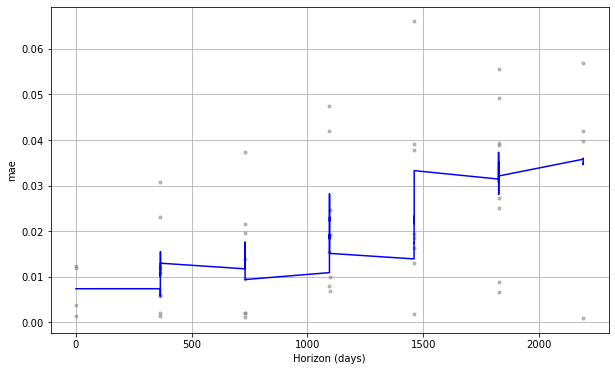

In [83]:
display(HTML('<span style="font-weight:bold">' + 'Cross Validation MAE' + '</span>'))
plot_cross_validation_metric(model_usa_cv, metric='mae');

In [84]:
future_usa = model_usa.make_future_dataframe(periods=10,
                                            freq='Y')
forecast_usa = model_usa.predict(future_usa)
display(HTML('<span style="font-weight:bold">' + 'Model Forecasting' + '</span>'))
forecast_usa[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
62,2011-12-31,1.046222,1.020522,1.072993
63,2012-12-31,1.055690,1.028470,1.081764
64,2013-12-31,1.065132,1.040080,1.090045
65,2014-12-31,1.074575,1.051114,1.101488
66,2015-12-31,1.084017,1.058417,1.110351
67,2016-12-31,1.093485,1.064931,1.119354
68,2017-12-31,1.102927,1.076349,1.129364
69,2018-12-31,1.112370,1.085640,1.140043
70,2019-12-31,1.121812,1.092584,1.152133
71,2020-12-31,1.131280,1.100689,1.163388


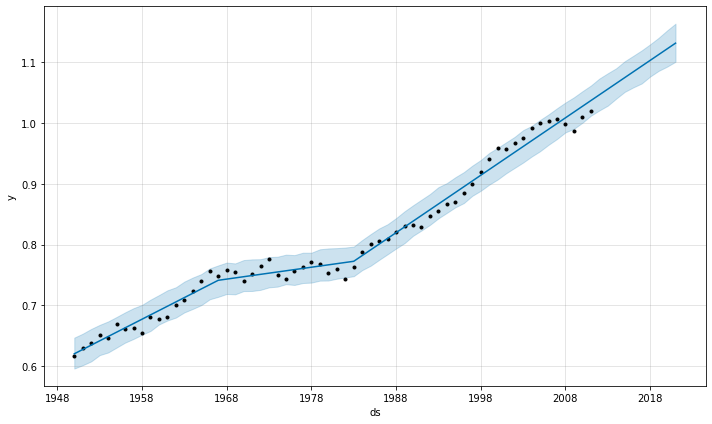

In [85]:
display(HTML('<span style="font-weight:bold">' + 'Model Plot with Uncertainty Levels' + '</span>'))
model_usa.plot(forecast_usa, uncertainty=True);

## 3.2 CAN Model

In [86]:
model_can = Prophet(interval_width=0.95, 
                    growth='linear',
                   yearly_seasonality=False,
                   seasonality_mode='additive')
model_can.fit(data_can)
model_can_cv = cross_validation(model_can, initial='40 Y', period='2 Y', horizon='6 Y')
display(HTML('<span style="font-weight:bold">' + 'Performance Mertrics'\
       + '</span>'), performance_metrics(model_can_cv).head())

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 1991-01-01 03:36:00 and 2004-12-31 13:04:48


,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 10:55:12,0.000710,0.026642,0.024944,0.024459,0.027941,1.00
1,364 days 20:24:00,0.000835,0.028893,0.028658,0.028283,0.027941,1.00
2,364 days 21:07:12,0.000711,0.026657,0.025615,0.025333,0.027337,1.00
3,364 days 21:50:24,0.001436,0.037900,0.033039,0.032176,0.027337,0.75
4,364 days 22:33:36,0.001420,0.037689,0.032766,0.031842,0.026668,0.75


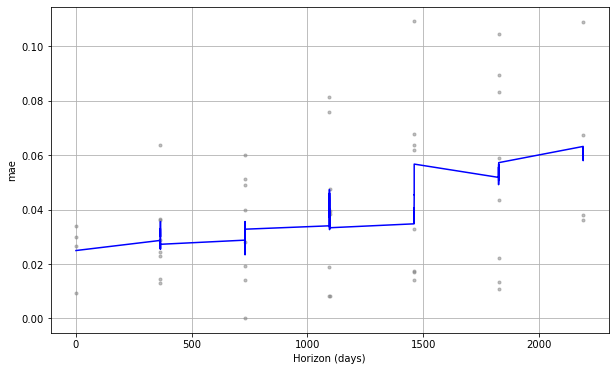

In [87]:
display(HTML('<span style="font-weight:bold">' + 'Cross Validation MAE' + '</span>'))
plot_cross_validation_metric(model_can_cv, metric='mae');

In [88]:
future_can = model_can.make_future_dataframe(periods=10,
                                            freq='Y')
forecast_can = model_can.predict(future_can)
display(HTML('<span style="font-weight:bold">' + 'Model Forecasting' + '</span>'))
forecast_can[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
62,2011-12-31,0.963330,0.917316,1.013060
63,2012-12-31,0.959942,0.908643,1.006611
64,2013-12-31,0.956564,0.908888,1.005571
65,2014-12-31,0.953185,0.903809,1.003875
66,2015-12-31,0.949807,0.896967,0.995797
67,2016-12-31,0.946419,0.895947,0.996990
68,2017-12-31,0.943040,0.892878,0.990798
69,2018-12-31,0.939662,0.893276,0.993690
70,2019-12-31,0.936283,0.890802,0.985525
71,2020-12-31,0.932895,0.885012,0.982691


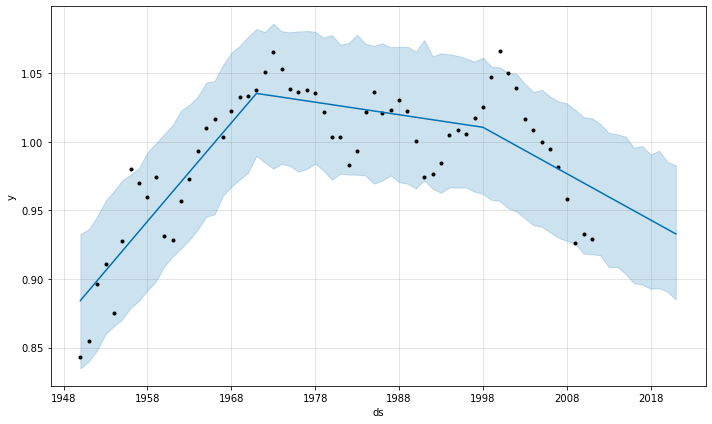

In [89]:
display(HTML('<span style="font-weight:bold">' + 'Model Plot with Uncertainty Levels' + '</span>'))
model_can.plot(forecast_can, uncertainty=True);

## 3.3 MEX Model

In [90]:
model_mex = Prophet(interval_width=0.95, 
                    growth='linear',
                   yearly_seasonality=False,
                   seasonality_mode='additive')
model_mex.fit(data_mex)
model_mex_cv = cross_validation(model_mex, initial='40 Y', period='2 Y', horizon='6 Y')
display(HTML('<span style="font-weight:bold">' + 'Performance Mertrics'\
       + '</span>'), performance_metrics(model_mex_cv).head())

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 8 forecasts with cutoffs between 1991-01-01 03:36:00 and 2004-12-31 13:04:48


,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 10:55:12,0.002467,0.049670,0.048744,0.046811,0.047675,1.00
1,364 days 20:24:00,0.002845,0.053342,0.052397,0.049973,0.054000,1.00
2,364 days 21:07:12,0.002123,0.046079,0.043804,0.041870,0.044560,1.00
3,364 days 21:50:24,0.003619,0.060157,0.053667,0.050610,0.044560,0.75
4,364 days 22:33:36,0.003477,0.058968,0.051353,0.048329,0.039997,0.75


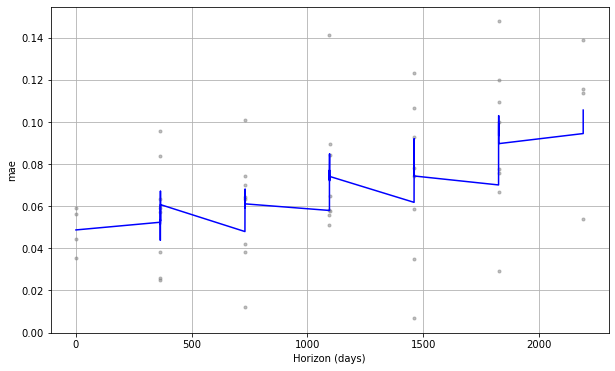

In [91]:
display(HTML('<span style="font-weight:bold">' + 'Cross Validation MAE' + '</span>'))
plot_cross_validation_metric(model_mex_cv, metric='mae');

In [92]:
future_mex = model_mex.make_future_dataframe(periods=10,
                                            freq='Y')
forecast_mex = model_mex.predict(future_mex)
display(HTML('<span style="font-weight:bold">' + 'Model Forecasting' + '</span>'))
forecast_mex[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
62,2011-12-31,0.932049,0.865302,0.998392
63,2012-12-31,0.923926,0.851806,0.991844
64,2013-12-31,0.915825,0.850186,0.984586
65,2014-12-31,0.907724,0.835279,0.975610
66,2015-12-31,0.899623,0.827760,0.971849
67,2016-12-31,0.891500,0.816817,0.965122
68,2017-12-31,0.883399,0.809716,0.956890
69,2018-12-31,0.875299,0.790740,0.955937
70,2019-12-31,0.867198,0.776733,0.957401
71,2020-12-31,0.859075,0.768544,0.948862


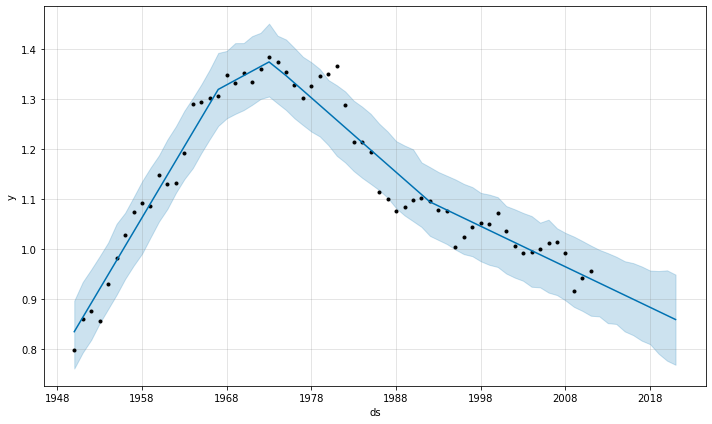

In [93]:
display(HTML('<span style="font-weight:bold">' + 'Model Plot with Uncertainty Levels' + '</span>'))
model_mex.plot(forecast_mex, uncertainty=True);

# 4. Analytical Question
### Can you think about another feature that could be helpful in explaining TFP series?